In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date_query[0][:10]
# Calculate the date 1 year ago from the last data point in the database
start_date = dt.date(2017,8,23) - dt.timedelta(days = 365)

start_date

datetime.date(2016, 8, 23)

In [11]:
# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>= start_date).\
    order_by(Measurement.date).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(year_prcp, columns = ['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace = True)

prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


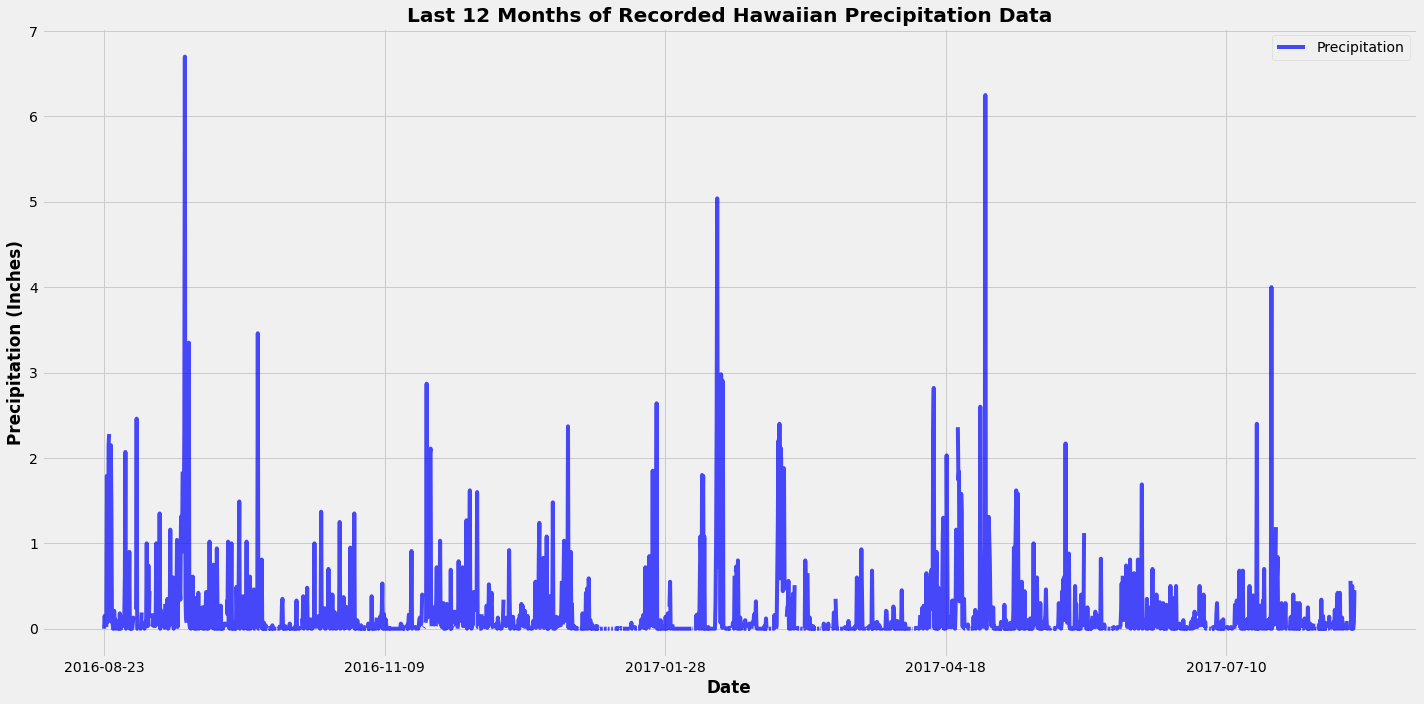

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
fig_1 = prcp_df.plot(figsize = (20,10), legend = True, grid = True, color = 'b', alpha=0.7)
plt.ylabel('Precipitation (Inches)', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title('Last 12 Months of Recorded Hawaiian Precipitation Data', weight = 'bold')
plt.tight_layout()

plt.savefig('Precipitation Chart')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
obsr_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).\
desc()).all()

obsr_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = func.min(Measurement.tobs)
max_temp = func.max(Measurement.tobs)
avg_temp = func.avg(Measurement.tobs)
session.query(min_temp, max_temp, avg_temp).all()


[(53.0, 87.0, 73.09795396419437)]

In [18]:
# Choose the station with the highest number of temperature observations.
most_active = session.query(Measurement.station).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).\
desc()).first()
most_active

('USC00519281')

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date>= start_date).all()
most_active_df = pd.DataFrame(most_active_data)

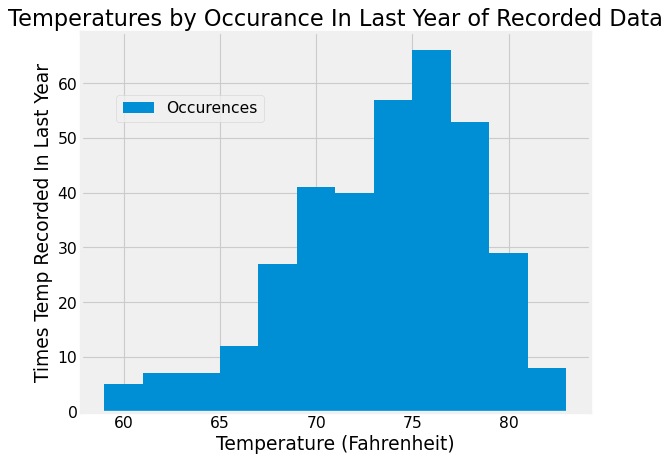

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(most_active_df['tobs'], bins = 12, label ="Occurences")
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Times Temp Recorded In Last Year')
plt.title('Temperatures by Occurance In Last Year of Recorded Data')
plt.legend('tobs')
plt.legend(bbox_to_anchor=(0.4,0.8),bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('Histogram')

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = '2018-08-10 to \n 2018-08-20'
tripStartDate = '2017-08-10'
tripEndDate = '2019-08-20'
tripTemps = calc_temps(tripStartDate, tripEndDate)
tripTemps

[(70.0, 78.71428571428571, 85.0)]

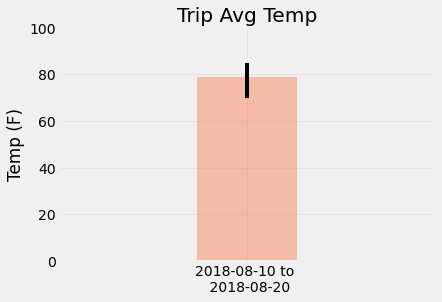

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha=0.3)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# precipitation per station on trip dates
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .filter(Measurement.date <= tripEndDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

stationRainTable = pd.DataFrame(np.array(stationRain))

stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.0,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.51,21.45167,-157.84888999999998,32.9
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.34,21.33556,-157.71139,19.5
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.04,21.5213,-157.8374,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.2716,-157.8168,3.0


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startDate = "2019-08-10"
endDate = "2019-08-20"

# Use the start and end date to create a range of dates
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

# Stip off the year and save a list of %m-%d strings
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0)],
 [(71.0, 76.98245614035088, 84.0)],
 [(71.0, 76.77777777777777, 82.0)],
 [(69.0, 76.47169811320755, 83.0)],
 [(69.0, 76.08, 83.0)],
 [(69.0, 76.125, 83.0)],
 [(70.0, 76.92307692307692, 84.0)],
 [(69.0, 75.94642857142857, 85.0)],
 [(68.0, 76.45283018867924, 82.0)]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0


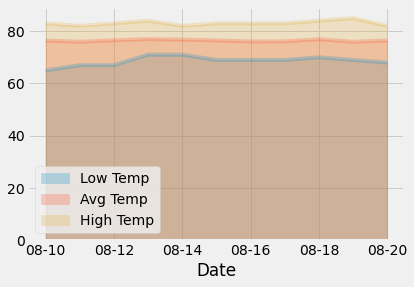

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.25)